In [ ]:
# Mounting the google colab file on google drive to import the dataset easily as the file is quite bulky (around 3.83 GB)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# pip installing pyspark to work this massive dataset
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pyspark.sql import SparkSession # Importing SparkSession function sql module inside pyspark library

In [ ]:
# importing usual libraries to work with dataframes and visualize them
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
spark = SparkSession.builder.appName('test_1').getOrCreate() # building an app name with getorCreat using SparkSession's builder class

In [ ]:
# importing the large dataset as a 'spark dataframe' from google drive using spark's read.csv function
df = spark.read.csv('/content/drive/MyDrive/Project/unbalaced_20_80_dataset.csv',inferSchema=True, header=True) 

In [ ]:
df.show() # showing the dataframe

+-------+--------------------+--------------+--------+-------------+--------+--------+--------------------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+------------------+---------------+---------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------+------------+-----------+------------------+------------------+-----------+-----------+-----------+--------------------+-------------------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+-------------------+-------------------+-----------+-----------+------------------+------------------+------------------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+------------------+----------------+------------------+--------------+--------------+----------------+

In [ ]:
df.printSchema() # printing the schema of the spark dataframe

root
 |-- _c0: integer (nullable = true)
 |-- Flow ID: string (nullable = true)
 |-- Src IP: string (nullable = true)
 |-- Src Port: integer (nullable = true)
 |-- Dst IP: string (nullable = true)
 |-- Dst Port: integer (nullable = true)
 |-- Protocol: integer (nullable = true)
 |-- Timestamp: string (nullable = true)
 |-- Flow Duration: integer (nullable = true)
 |-- Tot Fwd Pkts: integer (nullable = true)
 |-- Tot Bwd Pkts: integer (nullable = true)
 |-- TotLen Fwd Pkts: double (nullable = true)
 |-- TotLen Bwd Pkts: double (nullable = true)
 |-- Fwd Pkt Len Max: double (nullable = true)
 |-- Fwd Pkt Len Min: double (nullable = true)
 |-- Fwd Pkt Len Mean: double (nullable = true)
 |-- Fwd Pkt Len Std: double (nullable = true)
 |-- Bwd Pkt Len Max: double (nullable = true)
 |-- Bwd Pkt Len Min: double (nullable = true)
 |-- Bwd Pkt Len Mean: double (nullable = true)
 |-- Bwd Pkt Len Std: double (nullable = true)
 |-- Flow Byts/s: double (nullable = true)
 |-- Flow Pkts/s: double (nul

In [ ]:
df = df.na.drop('any') # dropping any null values

In [ ]:
df.groupBy('Label').count().show() # checking the value counts of each class after cleaning all null values

+------+-------+
| Label|  count|
+------+-------+
|  ddos|1294524|
|Benign|6292297|
+------+-------+



### Balance: We notice a heavy Imbalance for the dataset. Majority class: 'Benign'
Benign: 83% - DDOS: 17%

In [ ]:
from pyspark.sql.functions import col,isnan, when, count # importing useful function to check if there are any nulls in each column of the spark dataframe

In [ ]:
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show() # checking if there are any nulls in each column of the spark dataframe

+---+-------+------+--------+------+--------+--------+---------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+-----------+-----------+-------------+------------+------------+------------+-----------+------------+-----------+-----------+-----------+-----------+------------+-----------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+----------+----------+-----------+-----------+------------+-----------+-----------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+------------+----------------+----------------+--------------+--------------+----------------+--------------+--------------+----------------+----------------+----------------+----------------+----------------+-----------------+-----------------+-

### NO NULLS

### Now we need to make the class balanced. We will 'oversample' the 'minority class (ddos)' and make it equal the number of samples present in the 'majority class (benign)'. For this, we will create two seperate spark dataframe for each class and then evaluate the oversample ratio (by dividing the count of majority class dataframe by the count of minority class). And finally, replicating the minority class by 'oversample ratio' times.

In [ ]:
df_ddos = df.filter(df['Label']=='ddos') # creating a sperate spark dataframe for all samples with 'Label' = 'ddos'. Minority class spark dataframe
df_benign = df.filter(df['Label']=='Benign')# creating a sperate spark dataframe for all samples with 'Label' = 'ddos'. Majority class spark dataframe

In [ ]:
oversample_ratio = df_benign.count()/df_ddos.count() # evaluating oversample ratio

In [ ]:
df_ddos_oversampled = df_ddos.sample(withReplacement=True, fraction=oversample_ratio-1, seed=1) # oversampling the minority class spark dataframe

In [ ]:
df_final = df_benign.unionAll(df_ddos_oversampled) # concatenating the oversampled minority class with majority class spark dataframe

In [ ]:
df_final.show() # showinf the final spark dataframe

+-------+--------------------+---------------+--------+---------------+--------+--------+--------------------+-------------+------------+------------+---------------+---------------+---------------+---------------+------------------+------------------+---------------+---------------+------------------+------------------+--------------------+-------------------+------------------+------------------+------------+------------+------------+------------------+------------------+-----------+-----------+------------+------------------+------------------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+-------------------+-------------------+-----------+-----------+------------------+------------------+------------------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+------------------+------------------+------------------+--------------+--------------+---------

In [ ]:
df_final.groupBy('Label').count().show() # chacking the value counts of each label class in the final spark dataframe

+------+-------+
| Label|  count|
+------+-------+
|Benign|6292297|
|  ddos|4999488|
+------+-------+



### Balance: Now we see that the classess are now balanced. Now we can easily and correctly build and evaluate our Machine Learning model.
We didn't exactly balance the class (each class 50%) because we wanted to keep some similarity to the original spark dataframe
<p>Benign: 56% - DDOS: 44% 

In [ ]:
df_final.count() # checking the number of samples in the final spark dataframe

11291785

In [ ]:
my_cols_df_full = df_final.columns # making a list of all column names in final spark dataframe

In [ ]:
my_cols_df_full # checking the names of all column names in final spark dataframe

['_c0',
 'Flow ID',
 'Src IP',
 'Src Port',
 'Dst IP',
 'Dst Port',
 'Protocol',
 'Timestamp',
 'Flow Duration',
 'Tot Fwd Pkts',
 'Tot Bwd Pkts',
 'TotLen Fwd Pkts',
 'TotLen Bwd Pkts',
 'Fwd Pkt Len Max',
 'Fwd Pkt Len Min',
 'Fwd Pkt Len Mean',
 'Fwd Pkt Len Std',
 'Bwd Pkt Len Max',
 'Bwd Pkt Len Min',
 'Bwd Pkt Len Mean',
 'Bwd Pkt Len Std',
 'Flow Byts/s',
 'Flow Pkts/s',
 'Flow IAT Mean',
 'Flow IAT Std',
 'Flow IAT Max',
 'Flow IAT Min',
 'Fwd IAT Tot',
 'Fwd IAT Mean',
 'Fwd IAT Std',
 'Fwd IAT Max',
 'Fwd IAT Min',
 'Bwd IAT Tot',
 'Bwd IAT Mean',
 'Bwd IAT Std',
 'Bwd IAT Max',
 'Bwd IAT Min',
 'Fwd PSH Flags',
 'Bwd PSH Flags',
 'Fwd URG Flags',
 'Bwd URG Flags',
 'Fwd Header Len',
 'Bwd Header Len',
 'Fwd Pkts/s',
 'Bwd Pkts/s',
 'Pkt Len Min',
 'Pkt Len Max',
 'Pkt Len Mean',
 'Pkt Len Std',
 'Pkt Len Var',
 'FIN Flag Cnt',
 'SYN Flag Cnt',
 'RST Flag Cnt',
 'PSH Flag Cnt',
 'ACK Flag Cnt',
 'URG Flag Cnt',
 'CWE Flag Count',
 'ECE Flag Cnt',
 'Down/Up Ratio',
 'Pkt Size 

In [ ]:
from pyspark.sql.functions import dayofmonth, hour, dayofyear, month, year, weekofyear, format_number, date_format # importing important time functions

In [ ]:
df_final.select(df_final['Timestamp']).show() # checking the final spark dataframe's Timestamp column

+--------------------+
|           Timestamp|
+--------------------+
| 20/02/2018 10:36:27|
|04/07/2017 12:15:...|
| 20/02/2018 08:55:58|
| 20/02/2018 11:53:46|
| 20/02/2018 10:06:32|
| 20/02/2018 11:28:42|
| 20/02/2018 12:13:16|
| 20/02/2018 10:16:50|
| 20/02/2018 04:22:35|
| 20/02/2018 08:56:55|
| 20/02/2018 10:36:01|
|03/07/2017 06:39:...|
| 20/02/2018 05:10:09|
| 20/02/2018 02:42:50|
|03/07/2017 08:01:...|
| 20/02/2018 10:38:11|
| 20/02/2018 10:01:49|
|04/07/2017 12:25:...|
| 20/02/2018 11:17:24|
| 20/02/2018 02:54:06|
+--------------------+
only showing top 20 rows



In [ ]:
df_final.printSchema() # prinitng the schema of the final spark dataframe

root
 |-- _c0: integer (nullable = true)
 |-- Flow ID: string (nullable = true)
 |-- Src IP: string (nullable = true)
 |-- Src Port: integer (nullable = true)
 |-- Dst IP: string (nullable = true)
 |-- Dst Port: integer (nullable = true)
 |-- Protocol: integer (nullable = true)
 |-- Timestamp: string (nullable = true)
 |-- Flow Duration: integer (nullable = true)
 |-- Tot Fwd Pkts: integer (nullable = true)
 |-- Tot Bwd Pkts: integer (nullable = true)
 |-- TotLen Fwd Pkts: double (nullable = true)
 |-- TotLen Bwd Pkts: double (nullable = true)
 |-- Fwd Pkt Len Max: double (nullable = true)
 |-- Fwd Pkt Len Min: double (nullable = true)
 |-- Fwd Pkt Len Mean: double (nullable = true)
 |-- Fwd Pkt Len Std: double (nullable = true)
 |-- Bwd Pkt Len Max: double (nullable = true)
 |-- Bwd Pkt Len Min: double (nullable = true)
 |-- Bwd Pkt Len Mean: double (nullable = true)
 |-- Bwd Pkt Len Std: double (nullable = true)
 |-- Flow Byts/s: double (nullable = true)
 |-- Flow Pkts/s: double (nul

#### Cleaning out all string columns as pyspark.ml doesn't work properly with string inputs.

In [ ]:
str_columnList = [item[0] for item in df_final.dtypes if item[1].startswith('string')] # making a list of all string column names in final spark dataframe

In [ ]:
str_columnList # checking all string column name in final spark dataframe

['Flow ID', 'Src IP', 'Dst IP', 'Timestamp', 'Label']

In [ ]:
# making a list of all nonstring column names 
num_cols = [] # creating a blank list to store names of all non string column
for i in df_final.columns: # for each column in final spark dataframe
  if i not in str_columnList: # check if the name is present in the string column list
    num_cols.append(i) # if not, then append it in the list

In [ ]:
num_cols.append('Label') # appending the target label in the cleaned dataframe

In [ ]:
df_nums = df_final.select(num_cols) # creating a new cleaned spark dataframe which filters in only the non-string column (plus the target label column)

In [ ]:
df_nums.printSchema() # printing the new cleaned spark dataframe

root
 |-- _c0: integer (nullable = true)
 |-- Src Port: integer (nullable = true)
 |-- Dst Port: integer (nullable = true)
 |-- Protocol: integer (nullable = true)
 |-- Flow Duration: integer (nullable = true)
 |-- Tot Fwd Pkts: integer (nullable = true)
 |-- Tot Bwd Pkts: integer (nullable = true)
 |-- TotLen Fwd Pkts: double (nullable = true)
 |-- TotLen Bwd Pkts: double (nullable = true)
 |-- Fwd Pkt Len Max: double (nullable = true)
 |-- Fwd Pkt Len Min: double (nullable = true)
 |-- Fwd Pkt Len Mean: double (nullable = true)
 |-- Fwd Pkt Len Std: double (nullable = true)
 |-- Bwd Pkt Len Max: double (nullable = true)
 |-- Bwd Pkt Len Min: double (nullable = true)
 |-- Bwd Pkt Len Mean: double (nullable = true)
 |-- Bwd Pkt Len Std: double (nullable = true)
 |-- Flow Byts/s: double (nullable = true)
 |-- Flow Pkts/s: double (nullable = true)
 |-- Flow IAT Mean: double (nullable = true)
 |-- Flow IAT Std: double (nullable = true)
 |-- Flow IAT Max: double (nullable = true)
 |-- Flow

### Building the ML Model. We will use tree based model (as they work really good when it comes to classifying non-linear data). 
1) Decision Tree Classifier <p>
2) Random Forest Classifier<p>
3) Gradient Boosting Method Classifier

We will first create a vector assembler which will assemble all the numeric features in a vectorized format. Then, we will label encode the two classes Benign: 0 and ddos: 1. Then, we will split the dataset into test and train datasetin 30% to 70% ratio respectievely. 

We then train our model by fitting it on the training dataset and then doing prediction by transforming the test dataset. And then evaluate the predictions by using 'accuracy','f1-score' and 'auc_roc_score' as metrics.

In [ ]:
df_nums.show() # showing the df nums spark dataframe

+-------+--------+--------+--------+-------------+------------+------------+---------------+---------------+---------------+---------------+------------------+------------------+---------------+---------------+------------------+------------------+--------------------+-------------------+------------------+------------------+------------+------------+------------+------------------+------------------+-----------+-----------+------------+------------------+------------------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+-------------------+-------------------+-----------+-----------+------------------+------------------+------------------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+------------------+------------------+------------------+--------------+--------------+----------------+--------------+--------------+----------------+----------------+--

In [ ]:
from pyspark.ml.feature import VectorAssembler # importing vector assembler function to assemble all the training features

In [ ]:
df_nums.columns # checking columns of df_nums

['_c0',
 'Src Port',
 'Dst Port',
 'Protocol',
 'Flow Duration',
 'Tot Fwd Pkts',
 'Tot Bwd Pkts',
 'TotLen Fwd Pkts',
 'TotLen Bwd Pkts',
 'Fwd Pkt Len Max',
 'Fwd Pkt Len Min',
 'Fwd Pkt Len Mean',
 'Fwd Pkt Len Std',
 'Bwd Pkt Len Max',
 'Bwd Pkt Len Min',
 'Bwd Pkt Len Mean',
 'Bwd Pkt Len Std',
 'Flow Byts/s',
 'Flow Pkts/s',
 'Flow IAT Mean',
 'Flow IAT Std',
 'Flow IAT Max',
 'Flow IAT Min',
 'Fwd IAT Tot',
 'Fwd IAT Mean',
 'Fwd IAT Std',
 'Fwd IAT Max',
 'Fwd IAT Min',
 'Bwd IAT Tot',
 'Bwd IAT Mean',
 'Bwd IAT Std',
 'Bwd IAT Max',
 'Bwd IAT Min',
 'Fwd PSH Flags',
 'Bwd PSH Flags',
 'Fwd URG Flags',
 'Bwd URG Flags',
 'Fwd Header Len',
 'Bwd Header Len',
 'Fwd Pkts/s',
 'Bwd Pkts/s',
 'Pkt Len Min',
 'Pkt Len Max',
 'Pkt Len Mean',
 'Pkt Len Std',
 'Pkt Len Var',
 'FIN Flag Cnt',
 'SYN Flag Cnt',
 'RST Flag Cnt',
 'PSH Flag Cnt',
 'ACK Flag Cnt',
 'URG Flag Cnt',
 'CWE Flag Count',
 'ECE Flag Cnt',
 'Down/Up Ratio',
 'Pkt Size Avg',
 'Fwd Seg Size Avg',
 'Bwd Seg Size Avg',


In [ ]:
assembler = VectorAssembler(inputCols=df_nums.columns[1:-1], outputCol='features') # feeding in all the numeric columns (except the index) for creating a vector feature

In [ ]:
output = assembler.transform(df_nums) # transforming the numeric features to vectorized assembled feature

In [ ]:
from pyspark.ml.feature import StringIndexer # importing StringIndexer to label encode the target label column

In [ ]:
indexer = StringIndexer(inputCol='Label',outputCol='LabelIndex') # creating an String indexing instance which takes in 'Label' column and return 'LabelIndex' column

In [ ]:
output_fixed = indexer.fit(output).transform(output) # fitting and transforming the output spark dataframe

In [ ]:
output_fixed.printSchema() # checking the schema of fixed output spark dataframe

root
 |-- _c0: integer (nullable = true)
 |-- Src Port: integer (nullable = true)
 |-- Dst Port: integer (nullable = true)
 |-- Protocol: integer (nullable = true)
 |-- Flow Duration: integer (nullable = true)
 |-- Tot Fwd Pkts: integer (nullable = true)
 |-- Tot Bwd Pkts: integer (nullable = true)
 |-- TotLen Fwd Pkts: double (nullable = true)
 |-- TotLen Bwd Pkts: double (nullable = true)
 |-- Fwd Pkt Len Max: double (nullable = true)
 |-- Fwd Pkt Len Min: double (nullable = true)
 |-- Fwd Pkt Len Mean: double (nullable = true)
 |-- Fwd Pkt Len Std: double (nullable = true)
 |-- Bwd Pkt Len Max: double (nullable = true)
 |-- Bwd Pkt Len Min: double (nullable = true)
 |-- Bwd Pkt Len Mean: double (nullable = true)
 |-- Bwd Pkt Len Std: double (nullable = true)
 |-- Flow Byts/s: double (nullable = true)
 |-- Flow Pkts/s: double (nullable = true)
 |-- Flow IAT Mean: double (nullable = true)
 |-- Flow IAT Std: double (nullable = true)
 |-- Flow IAT Max: double (nullable = true)
 |-- Flow

In [ ]:
output_fixed.show() # checking the output_fixed dataframe

+-------+--------+--------+--------+-------------+------------+------------+---------------+---------------+---------------+---------------+------------------+------------------+---------------+---------------+------------------+------------------+--------------------+-------------------+------------------+------------------+------------+------------+------------+------------------+------------------+-----------+-----------+------------+------------------+------------------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+-------------------+-------------------+-----------+-----------+------------------+------------------+------------------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+------------------+------------------+------------------+--------------+--------------+----------------+--------------+--------------+----------------+----------------+--

In [ ]:
final_data = output_fixed.select(['features','LabelIndex']) # for final data we only need the vectorized feature and LabelIndex columns

In [ ]:
final_data.show() # showing the final spark dataframe

+--------------------+----------+
|            features|LabelIndex|
+--------------------+----------+
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|[56889.0,3389.0,6...|       0.0|
|[51263.0,443.0,6....|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,17...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,17...|       0.0|
|[57775.0,3389.0,6...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|[49411.0,80.0,6.0...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|[52095.0,80.0,6.0...|       0.0|
+--------------------+----------+
only showing top 20 rows



In [ ]:
final_data = final_data.na.drop() # dropping any nulls (if any) from final sparl dataframe 
final_data.show() # showing the cleaned final dataframe

+--------------------+----------+
|            features|LabelIndex|
+--------------------+----------+
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|[56889.0,3389.0,6...|       0.0|
|[51263.0,443.0,6....|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,17...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,17...|       0.0|
|[57775.0,3389.0,6...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|[49411.0,80.0,6.0...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|[52095.0,80.0,6.0...|       0.0|
+--------------------+----------+
only showing top 20 rows



In [ ]:
output_fixed.count() # checking the length of output fixed spark dataframe

11291785

In [ ]:
final_data_2 = final_data.sample(0.001,3) 

In [ ]:
train_data, test_data = final_data.randomSplit([7.,3.]) # splitting the final spark dataframe into train and test set with a split ratio of 70% and 30% respectievely.

### Using Tree Based models and Logistic regression

In [ ]:
final_data.show() # showing final data spark dataframe

+--------------------+----------+
|            features|LabelIndex|
+--------------------+----------+
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|[56889.0,3389.0,6...|       0.0|
|[51263.0,443.0,6....|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,17...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,17...|       0.0|
|[57775.0,3389.0,6...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|[49411.0,80.0,6.0...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|[52095.0,80.0,6.0...|       0.0|
+--------------------+----------+
only showing top 20 rows



In [ ]:
train_data.show() # showing train data spark dataframe

+--------------------+----------+
|            features|LabelIndex|
+--------------------+----------+
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
+--------------------+----------+
only showing top 20 rows



In [ ]:
test_data.show() # showing test data spark dataframe

+--------------------+----------+
|            features|LabelIndex|
+--------------------+----------+
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|
+--------------------+----------+
only showing top 20 rows



In [ ]:
train_data.groupBy('LabelIndex').count().show() # showing value count of each label in train data train data spark dataframe. Ratio is approx. 55%-45% (pretty much balanced)

+----------+-------+
|LabelIndex|  count|
+----------+-------+
|       0.0|4403336|
|       1.0|3501445|
+----------+-------+



In [ ]:
test_data.groupBy('LabelIndex').count().show() # showing value count of each label in test data train data spark dataframe. Ratio is approx. 55%-45% (pretty much balanced)

+----------+-------+
|LabelIndex|  count|
+----------+-------+
|       0.0|1888961|
|       1.0|1498043|
+----------+-------+



In [ ]:
from pyspark.ml import Pipeline # importing Pipeline function to build pipelines for ML model implementation
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, DecisionTreeClassifier # importing random forest, gradient boosting and Gradient Boosting Classifier function

In [ ]:
dt = DecisionTreeClassifier(labelCol='LabelIndex',featuresCol='features') # creating an instance of the Decision Tree Classifier
rf = RandomForestClassifier(numTrees=100,labelCol='LabelIndex',featuresCol='features') # creating an instance of the Random Forest Classifier
gbt = GBTClassifier(labelCol='LabelIndex',featuresCol='features') # creating an instance of the Gradient Boosting Method Classifier

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator # importing function to measure classification metrics: accuracy, f1-score and auc_roc_score

In [ ]:
my_binary_eval = BinaryClassificationEvaluator(labelCol='LabelIndex') # creating  an instance to calculate auc_roc_score. Fits on labelindex column

In [ ]:
evaluatorMulti = MulticlassClassificationEvaluator(labelCol="LabelIndex", predictionCol="prediction") # creating  an instance to calculate accuracy and f1_score.
# Takes in LabelIndex column and compares it with column 'prediction'

### 1) Decision Tree

In [ ]:
dt_model = dt.fit(train_data) # fitting the decision tree classifier instance on train data
dt_preds = dt_model.transform(test_data) # calcualting predicted value by trnasforming the test data
acc_dt = evaluatorMulti.evaluate(dt_preds, {evaluatorMulti.metricName: "accuracy"}) # calculating accuracy of the decision tree model 
auc_dt = my_binary_eval.evaluate(dt_preds) # calculating auc_roc_score of the decision tree model 
f1_dt = evaluatorMulti.evaluate(dt_preds, {evaluatorMulti.metricName: "f1"}) # calculating f1_score of the decision tree model 
print('\n')
print(f"accuracy: {acc_dt}")
print('\n')
print(f"auc score: {auc_dt}")
print('\n')
print(f"f1-score: {f1_dt}")



accuracy: 0.9855556710296179


auc score: 0.9950553486711704


f1-score: 0.985571866523323


In [ ]:
dt_preds.show() # showing the dt_preds spark dataframe

+--------------------+----------+-----------------+--------------------+----------+
|            features|LabelIndex|    rawPrediction|         probability|prediction|
+--------------------+----------+-----------------+--------------------+----------+
|(79,[0,1,2,3,4,5,...|       0.0|[249927.0,4312.0]|[0.98303958086682...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|[249927.0,4312.0]|[0.98303958086682...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|[249927.0,4312.0]|[0.98303958086682...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|[249927.0,4312.0]|[0.98303958086682...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|[249927.0,4312.0]|[0.98303958086682...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|[249927.0,4312.0]|[0.98303958086682...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|[249927.0,4312.0]|[0.98303958086682...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|[249927.0,4312.0]|[0.98303958086682...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|[249927.0,4312.0]|[0.98303958086682...|    

In [ ]:
dt_model.featureImportances # checking the feature importance of each column

SparseVector(79, {0: 0.0003, 1: 0.0286, 6: 0.033, 7: 0.0008, 15: 0.0012, 18: 0.0178, 20: 0.064, 39: 0.0184, 46: 0.0056, 68: 0.0999, 69: 0.0171, 70: 0.7133})

In [ ]:
# storing the feature importance score for decision tree classifier
feat_imp_dt = [] # creating an empty list to store feat imp. score
for i in dt_model.featureImportances: # iterating the for loop
  feat_imp_dt.append(i) # appending the list to store feat imp. score of each feature

In [ ]:
len(feat_imp_dt) # checking the length of list that stores feat imp. scores

79

In [ ]:
# creating a dataframe that stores feature names in column 'Feature Name' and feature imp. score in 'Feature Importance' column
df_feat_imp_dt = pd.DataFrame({'Feature Name':df_nums.columns[1:-1],'Feature Importance':feat_imp_dt}) 
df_feat_imp_dt

,Feature Name,Feature Importance
0,Src Port,0.000323
1,Dst Port,0.028621
2,Protocol,0.000000
3,Flow Duration,0.000000
4,Tot Fwd Pkts,0.000000
...,...,...
74,Active Min,0.000000
75,Idle Mean,0.000000
76,Idle Std,0.000000
77,Idle Max,0.000000


In [ ]:
# setting the index to 'Feature Name' column and dropping off the redundant column
df_feat_imp_dt.index = df_feat_imp_dt['Feature Name']
df_feat_imp_dt.drop('Feature Name',axis=1,inplace=True)
df_feat_imp_dt

,Feature Importance
Feature Name,
Src Port,0.000323
Dst Port,0.028621
Protocol,0.000000
Flow Duration,0.000000
Tot Fwd Pkts,0.000000
...,...
Active Min,0.000000
Idle Mean,0.000000
Idle Std,0.000000


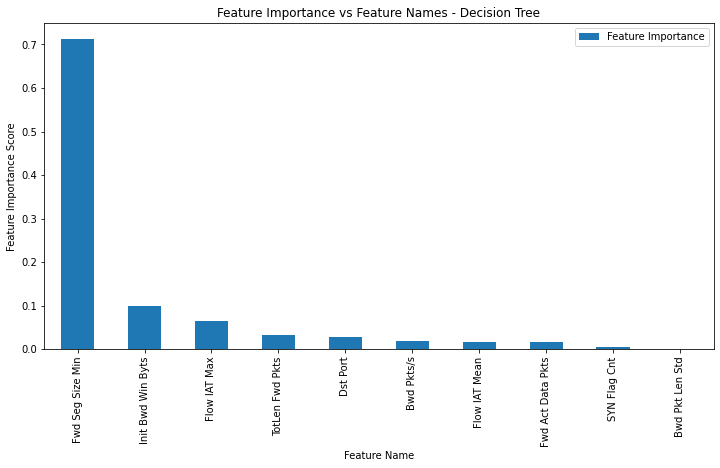

In [ ]:
# plotting the barplot for top 10 features with highest feature importance score
df_feat_imp_dt.sort_values(by='Feature Importance',ascending=False).head(10).plot(kind='bar',figsize=(12,6))
plt.xlabel('Feature Name') # setting the x-axis label
plt.ylabel('Feature Importance Score') # setting the y-axis label
plt.title('Feature Importance vs Feature Names - Decision Tree') # setting the plot title
plt.show(); # show the resulting plot

### 2) Random Forest

In [66]:
rf_model = rf.fit(train_data) # fitting the Random Forest classifier instance on train data
rf_preds = rf_model.transform(test_data) # calcualting predicted value by transforming the test data
acc_rf = evaluatorMulti.evaluate(rf_preds, {evaluatorMulti.metricName: "accuracy"}) # calculating accuracy of the Random Forest model 
auc_rf = my_binary_eval.evaluate(rf_preds)# calculating auc_roc_score of the Random Forest model 
f1_rf = evaluatorMulti.evaluate(rf_preds, {evaluatorMulti.metricName: "f1"}) # calculating f1_score of the Random Forest model 
print('\n')
print(f"accuracy: {acc_rf}")
print('\n')
print(f"auc score: {auc_rf}")
print('\n')
print(f"f1-score: {f1_rf}")



accuracy: 0.991284627948476


auc score: 0.9994962150375447


f1-score: 0.9912846944305242


In [67]:
rf_preds.show() # showing the rf_preds spark dataframe

+--------------------+----------+--------------------+--------------------+----------+
|            features|LabelIndex|       rawPrediction|         probability|prediction|
+--------------------+----------+--------------------+--------------------+----------+
|(79,[0,1,2,3,4,5,...|       0.0|[90.8343372684061...|[0.90834337268406...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|[90.8343372684061...|[0.90834337268406...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|[95.6750442263259...|[0.95675044226325...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|[97.8736122134442...|[0.97873612213444...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|[95.4658225109179...|[0.95465822510917...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|[97.8736122134442...|[0.97873612213444...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|[98.0893635524409...|[0.98089363552440...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|[97.8736122134442...|[0.97873612213444...|       0.0|
|(79,[0,1,2,3,4,5,...|       0.0|[97.977822

In [68]:
rf_model.featureImportances # feature importance of features used to build the Random Forest Classifier model

SparseVector(79, {0: 0.0171, 1: 0.0348, 2: 0.0128, 3: 0.0114, 4: 0.0236, 5: 0.0091, 6: 0.0109, 7: 0.0091, 8: 0.0368, 9: 0.0089, 10: 0.0285, 11: 0.0491, 12: 0.0054, 13: 0.0175, 14: 0.0028, 15: 0.0029, 16: 0.0091, 17: 0.0206, 18: 0.0146, 19: 0.0011, 20: 0.0093, 21: 0.0161, 22: 0.0181, 23: 0.003, 24: 0.0108, 25: 0.0062, 26: 0.0031, 27: 0.0003, 28: 0.0002, 29: 0.002, 30: 0.0011, 31: 0.0015, 32: 0.0, 33: 0.0001, 36: 0.0115, 37: 0.0544, 38: 0.0168, 39: 0.0084, 40: 0.008, 41: 0.0172, 42: 0.0104, 43: 0.0119, 44: 0.0055, 45: 0.001, 46: 0.0072, 47: 0.0005, 48: 0.0086, 49: 0.0168, 50: 0.0013, 51: 0.004, 52: 0.0002, 53: 0.0076, 54: 0.0058, 55: 0.0312, 56: 0.0042, 63: 0.026, 64: 0.0316, 65: 0.0071, 66: 0.0051, 67: 0.0729, 68: 0.0781, 69: 0.0166, 70: 0.1244, 71: 0.0003, 72: 0.0, 73: 0.0, 74: 0.0001, 75: 0.0028, 76: 0.0001, 77: 0.0011, 78: 0.0036})

In [69]:
df_nums.columns[1:-1] # Feature names used to build the Random Forest Classifier model

['Src Port',
 'Dst Port',
 'Protocol',
 'Flow Duration',
 'Tot Fwd Pkts',
 'Tot Bwd Pkts',
 'TotLen Fwd Pkts',
 'TotLen Bwd Pkts',
 'Fwd Pkt Len Max',
 'Fwd Pkt Len Min',
 'Fwd Pkt Len Mean',
 'Fwd Pkt Len Std',
 'Bwd Pkt Len Max',
 'Bwd Pkt Len Min',
 'Bwd Pkt Len Mean',
 'Bwd Pkt Len Std',
 'Flow Byts/s',
 'Flow Pkts/s',
 'Flow IAT Mean',
 'Flow IAT Std',
 'Flow IAT Max',
 'Flow IAT Min',
 'Fwd IAT Tot',
 'Fwd IAT Mean',
 'Fwd IAT Std',
 'Fwd IAT Max',
 'Fwd IAT Min',
 'Bwd IAT Tot',
 'Bwd IAT Mean',
 'Bwd IAT Std',
 'Bwd IAT Max',
 'Bwd IAT Min',
 'Fwd PSH Flags',
 'Bwd PSH Flags',
 'Fwd URG Flags',
 'Bwd URG Flags',
 'Fwd Header Len',
 'Bwd Header Len',
 'Fwd Pkts/s',
 'Bwd Pkts/s',
 'Pkt Len Min',
 'Pkt Len Max',
 'Pkt Len Mean',
 'Pkt Len Std',
 'Pkt Len Var',
 'FIN Flag Cnt',
 'SYN Flag Cnt',
 'RST Flag Cnt',
 'PSH Flag Cnt',
 'ACK Flag Cnt',
 'URG Flag Cnt',
 'CWE Flag Count',
 'ECE Flag Cnt',
 'Down/Up Ratio',
 'Pkt Size Avg',
 'Fwd Seg Size Avg',
 'Bwd Seg Size Avg',
 'Fwd By

In [70]:
len(df_nums.columns[1:-1]) # number of Features used to build the Random Forest Classifier model

79

In [71]:
len(rf_model.featureImportances) # number of Features used to build the Random Forest Classifier model

79

In [72]:
cols_name = df_nums.columns[1:-1] # taking the names of all those Features used to build the Random Forest Classifier model

In [73]:
# storing the feature importance score for Random Forest classifier
feature_importance = [] # creating an empty list to store feat imp. score
for i in rf_model.featureImportances: # iterating the for loop
  feature_importance.append(i) # appending the list to store feat imp. score of each feature

In [74]:
# creating a dataframe that stores feature names in column 'Feature Name' and feature imp. score in 'Feature Importance' column
df_feat_imp = pd.DataFrame({'Feature Name': cols_name, 'Feature Importance':feature_importance})

In [75]:
df_feat_imp.index = df_feat_imp['Feature Name'] # setting the index to Feature Name column

In [76]:
df_feat_imp.drop('Feature Name',inplace=True,axis=1) # dropping off the redundant Feature Name column

In [77]:
df_feat_imp.sort_values(by='Feature Importance',ascending=False).head(20) # checking the top 10 Features with highest Feature Importance Score

,Feature Importance
Feature Name,
Fwd Seg Size Min,0.124390
Init Bwd Win Byts,0.078132
Init Fwd Win Byts,0.072880
Bwd Header Len,0.054426
Fwd Pkt Len Std,0.049098
Fwd Pkt Len Max,0.036755
Dst Port,0.034815
Subflow Fwd Byts,0.031644
Fwd Seg Size Avg,0.031151


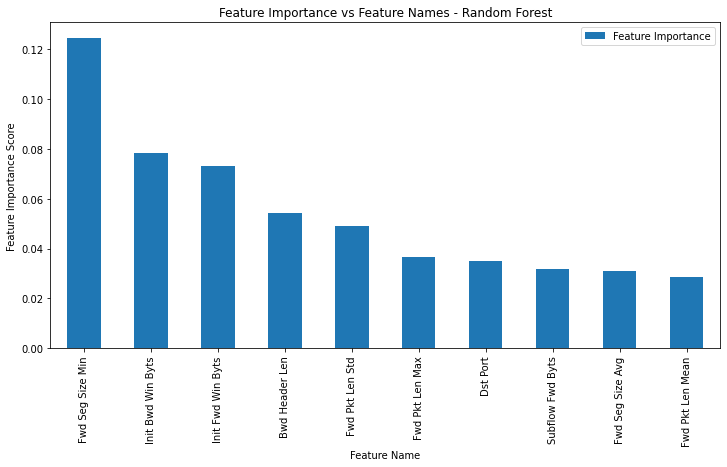

In [78]:
# plotting the barplot for top 10 features with highest feature importance score
df_feat_imp.sort_values(by='Feature Importance',ascending=False).head(10).plot(kind='bar',figsize=(12,6))
plt.xlabel('Feature Name') # setting the x-axis label
plt.ylabel('Feature Importance Score') # setting the y-axis label
plt.title('Feature Importance vs Feature Names - Random Forest') # setting the plot title
plt.show(); # show the resulting plot

### 3) Gradient Boosting Tree

In [79]:
gbt_model = gbt.fit(train_data) # fitting the Gradient Boosting Tree classifier instance on train data
gbt_preds = gbt_model.transform(test_data) # calcualting predicted value by transforming the test data
acc_gbt = evaluatorMulti.evaluate(gbt_preds, {evaluatorMulti.metricName: "accuracy"}) # calculating accuracy of the Gradient Boosting Tree model 
auc_gbt = my_binary_eval.evaluate(gbt_preds) # calculating auc_roc_score of the Gradient Boosting Tree model 
f1_gbt = evaluatorMulti.evaluate(gbt_preds, {evaluatorMulti.metricName: "f1"}) # calculating f1_score of the Gradient Boosting Tree model
print('\n')
print(f"accuracy: {acc_gbt}")
print('\n')
print(f"auc score: {auc_gbt}")
print('\n')
print(f"f1-score: {f1_gbt}")



accuracy: 0.9958824967434347


auc score: 0.9991128955959023


f1-score: 0.9958837045819233


In [80]:
gbt_model.featureImportances # feature importance of features used to build the Gradient Boosting Tree Classifier model

SparseVector(79, {0: 0.0217, 1: 0.0348, 3: 0.0118, 4: 0.0082, 5: 0.0014, 6: 0.012, 7: 0.0006, 8: 0.0229, 9: 0.0015, 10: 0.0003, 11: 0.0001, 12: 0.0007, 14: 0.0, 15: 0.0112, 16: 0.0, 17: 0.01, 18: 0.0105, 19: 0.0013, 20: 0.021, 21: 0.014, 22: 0.0335, 23: 0.0, 24: 0.0013, 25: 0.0005, 26: 0.0025, 27: 0.0, 28: 0.0, 30: 0.0, 31: 0.0046, 33: 0.0004, 36: 0.0042, 38: 0.0065, 39: 0.0041, 41: 0.0058, 42: 0.0, 43: 0.0, 45: 0.0011, 46: 0.0005, 47: 0.0, 49: 0.0011, 54: 0.0, 55: 0.0012, 67: 0.0074, 68: 0.0942, 69: 0.0069, 70: 0.6253, 74: 0.0003, 75: 0.0017, 76: 0.0, 77: 0.0018, 78: 0.0109})

In [81]:
# storing the feature importance score for Gradient Boosting Tree classifier
feat_imp_gbt=[] # creating an empty list to store feat imp. score
for i in gbt_model.featureImportances: # iterating the for loop
  feat_imp_gbt.append(i) # appending the list to store feat imp. score of each feature

In [82]:
# creating a dataframe that stores feature names in column 'Feature Name' and feature imp. score in 'Feature Importance' column
df_feat_imp_gbt = pd.DataFrame({'Feature Name':df_nums.columns[1:-1], 'Feature Importance': feat_imp_gbt})
df_feat_imp_gbt

,Feature Name,Feature Importance
0,Src Port,0.021707
1,Dst Port,0.034832
2,Protocol,0.000000
3,Flow Duration,0.011828
4,Tot Fwd Pkts,0.008200
...,...,...
74,Active Min,0.000286
75,Idle Mean,0.001676
76,Idle Std,0.000018
77,Idle Max,0.001833


In [83]:
df_feat_imp_gbt.index = df_feat_imp_gbt['Feature Name'] # setting the index to 'Feature Name' column
df_feat_imp_gbt.drop('Feature Name',axis=1,inplace=True) # dropping off redundant column 'Feature Name'
df_feat_imp_gbt

,Feature Importance
Feature Name,
Src Port,0.021707
Dst Port,0.034832
Protocol,0.000000
Flow Duration,0.011828
Tot Fwd Pkts,0.008200
...,...
Active Min,0.000286
Idle Mean,0.001676
Idle Std,0.000018


In [84]:
df_feat_imp_gbt.sort_values(by='Feature Importance',ascending=False).head(10) # checking the top 10 Features with highest Feature Importance Score

,Feature Importance
Feature Name,
Fwd Seg Size Min,0.625329
Init Bwd Win Byts,0.094196
Dst Port,0.034832
Fwd IAT Tot,0.033538
Fwd Pkt Len Max,0.022906
Src Port,0.021707
Flow IAT Max,0.021032
Flow IAT Min,0.014017
TotLen Fwd Pkts,0.011992


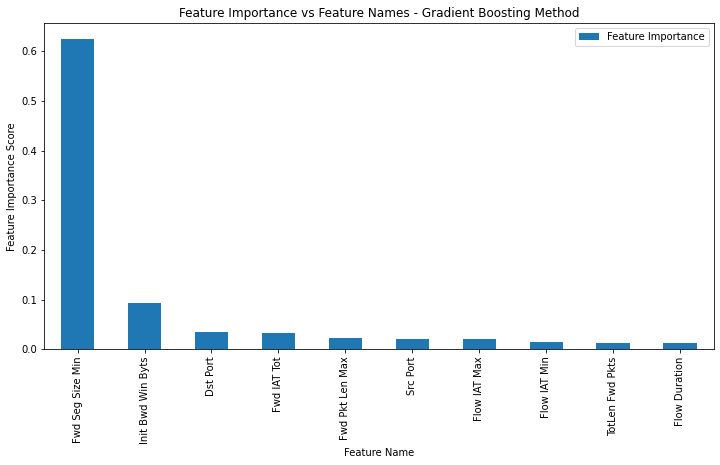

In [85]:
# plotting the barplot for top 10 features with highest feature importance score
df_feat_imp_gbt.sort_values(by='Feature Importance',ascending=False).head(10).plot(kind='bar',figsize=(12,6)) # setting the x-axis label
plt.xlabel('Feature Name') # setting the y-axis label
plt.ylabel('Feature Importance Score') # setting the plot title
plt.title('Feature Importance vs Feature Names - Gradient Boosting Method')
plt.show(); # show the resulting plot